In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as Tfs
import matplotlib.pyplot as plt
import torchvision.models as models
import numpy as np
from PIL import Image

In [2]:
#import wandb
#wandb.init(project='ganstuff')

In [3]:
from models.DeepGan import DeepGAN

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
from datasets.facesDataset import DataSet

In [6]:
ds = DataSet()
tds, valds = torch.utils.data.random_split(ds, [len(ds) - 200, 200])

In [7]:
print(len(tds))

12943


(<matplotlib.image.AxesImage at 0x1c0a4227790>, 0)

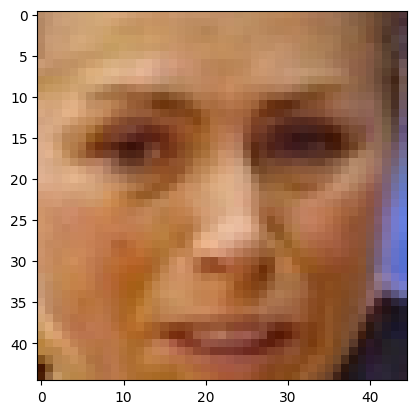

In [8]:
idx = -148
plt.imshow(0.5*(tds[idx][0].permute(1,2,0)) + 0.5), tds[idx][1]

In [9]:
def print_gpu_mem():
    print(f'{(torch.cuda.memory_allocated(device) / (1024**3)):.2f}', '/',
         f'{(torch.cuda.get_device_properties(device).total_memory/1024**3):.2f}', 'GBs')

In [10]:
def unroll_batch(batch, num_rows, num_cols):
    rows = []
    num_rows = num_rows
    num_cols = num_cols
    for i in range(num_rows):
        for j in range(num_cols):
            if j== 0:
                rows.append(batch[(i*num_cols),:,:,:].view(batch.shape[1],batch.shape[2],batch.shape[3]))
            else:
                rows[i] = torch.cat((rows[i], batch[(i*num_cols + j),:,:,:].view(batch.shape[1],batch.shape[2],batch.shape[3])), dim=2)

    for i in range(1, len(rows)):
        rows[0] = torch.cat((rows[0], rows[i]), dim=1)
    return rows[0] 
        

In [11]:
def train(model, Dlr, Glr, epochs, batch_size, tds, valds):
    model.to(device).train()
    tdl = torch.utils.data.DataLoader(tds, batch_size=batch_size, shuffle=True, drop_last=True)
    vdl = torch.utils.data.DataLoader(valds, batch_size=batch_size, shuffle=False, drop_last=False)

    ##make optimizers for both D and G
    D_optim = torch.optim.Adam(model.D.parameters(), lr=Dlr, weight_decay=1e-5)
    G_optim = torch.optim.Adam(model.G.parameters(), lr=Glr, weight_decay=1e-5)
    
    train_dloss = []
    val_dloss = []
    train_gloss = []
    val_gloss = []

    train_dacc = []
    val_dacc = []
    train_gacc = []
    val_gacc = []
    for epoch in range(epochs):
        train_dloss_batch = []
        val_dloss_batch = []
        train_gloss_batch = []
        val_gloss_batch = []

        train_dacc_batch = []
        val_dacc_batch = []
        train_gacc_batch = []
        val_gacc_batch = []
        model.train()
        for xb, labels in tdl:
            xb = xb.to(device)
            labels = labels.to(device)
            D_optim.zero_grad()
            d_loss, d_acc = model.D_trainstep(xb, labels, batch_size, D_optim)
            G_optim.zero_grad()
            g_loss, g_acc, gen_imgs = model.G_trainstep(batch_size, G_optim, num_samples=1)
            D_optim.zero_grad()
            d_loss, d_acc = model.D_trainstep(xb, labels, batch_size, D_optim)

            train_dloss_batch.append(d_loss.item())
            train_gloss_batch.append(g_loss.item())
            train_dacc_batch.append(d_acc)
            train_gacc_batch.append(g_acc)
            
            del(xb); del(labels); del(gen_imgs)
            torch.cuda.empty_cache()

        model.eval()
        with torch.no_grad():
            for idx, (vxb, vlabels) in enumerate(vdl):
                vxb = vxb.to(device)
                vlabels = vlabels.to(device)
                vd_loss, vd_acc = model.D_valstep(vxb, vlabels, vxb.shape[0])

                val_dloss_batch.append(vd_loss.item())
                val_dacc_batch.append(vd_acc)

                if idx == len(vdl) - 1:
                  ##print reconstruction validation example
                  ##create new images
                  generated = model.G(torch.randn(10*4,model.zdim*2).to(device), torch.zeros(40).long().to(device))
                  generated = unroll_batch(generated, 4, 10)
                  plt.imshow(0.5*generated.to('cpu').permute(1,2,0) + 0.5); plt.show()
                  gimg = Image.fromarray(np.array((generated.to('cpu').permute(1,2,0)*255), dtype=np.uint8))
                  #wandb.log({'generated_images':wandb.Image(gimg)})
                  del(generated); del(gimg)
        
        train_dloss.append(np.mean(train_dloss_batch))
        val_dloss.append(np.mean(val_dloss_batch))
        train_gloss.append(np.mean(train_gloss_batch))

        train_dacc.append(np.mean(train_dacc_batch))
        val_dacc.append(np.mean(val_dacc_batch))
        train_gacc.append(np.mean(train_gacc_batch))

        print('Epoch', epoch+1, 'Train-D-Loss', f'{train_dloss[epoch]:.5f}',
              'Train-D-Acc', f'{train_dacc[epoch]:.5f}')
        print('Val-D-Loss', f'{val_dloss[epoch]:.5f}',
              'Val-D-Acc', f'{val_dacc[epoch]:.5f}')
        print('Train-G-Loss', f'{train_gloss[epoch]:.5f}',
              'Train-G-Acc', f'{train_gacc[epoch]:.5f}')
        #wandb.log({"train_loss_512Latent": np.mean(losses), "val_loss_512Latent": np.mean(val_losses)})
        if (epoch + 1 <= 5): 
            print_gpu_mem()

In [12]:
model = DeepGAN(resolution=45, ch=96)

In [13]:
##hyperparams
epochs = 1000
batch_size = 512
#lr = 0.001 - batchsize=1024, pretrainedresnet,sgd
Dlr = 2*1e-4
Glr = 5*1e-5


In [14]:
print_gpu_mem()

0.00 / 23.99 GBs


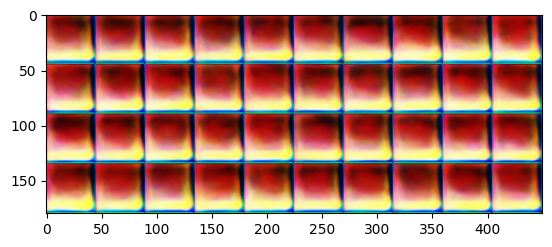

Epoch 1 Train-D-Loss 0.57900 Train-D-Acc 0.03195
Val-D-Loss 1.00000 Val-D-Acc 0.00000
Train-G-Loss 0.14137 Train-G-Acc 0.09922
0.36 / 23.99 GBs


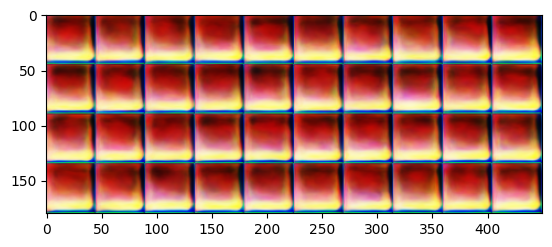

Epoch 2 Train-D-Loss 0.99975 Train-D-Acc 0.00000
Val-D-Loss 1.00000 Val-D-Acc 0.00000
Train-G-Loss 0.00000 Train-G-Acc 0.10289
0.36 / 23.99 GBs


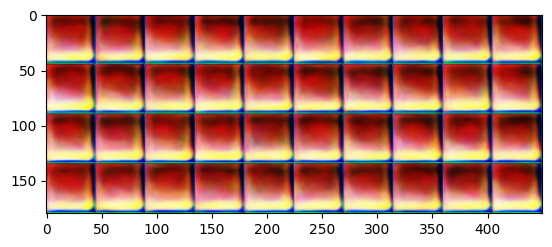

Epoch 3 Train-D-Loss 0.99977 Train-D-Acc 0.00000
Val-D-Loss 1.00000 Val-D-Acc 0.00000
Train-G-Loss 0.00000 Train-G-Acc 0.09914
0.36 / 23.99 GBs


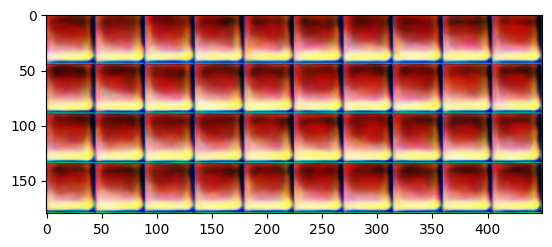

Epoch 4 Train-D-Loss 0.99984 Train-D-Acc 0.00000
Val-D-Loss 1.00000 Val-D-Acc 0.00000
Train-G-Loss 0.00000 Train-G-Acc 0.10250
0.36 / 23.99 GBs


KeyboardInterrupt: 

In [15]:
train(model, Dlr, Glr, epochs, batch_size, tds, valds)

In [ ]:
model.G

In [ ]:
torch.randint(low=1, high=5, size=(20,))

In [ ]:
asdf = torch.randn(3,21)
b = torch.argmax(asdf, dim=1)
b

In [ ]:
#torch.save(model.state_dict(), 'horsecarembeddings.pt')

In [ ]:
model.load_state_dict(torch.load('frogcarepoch342.pt'))
model.eval()
pass

In [ ]:
example = model.G(torch.randn(2,256), torch.zeros(2,).long())

In [ ]:
plt.imshow(0.5*example[0].detach().to('cpu').permute(1,2,0) + 0.5)

In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

from glob import glob
import os
from scipy import misc

IMAGE_EXTS = ['.png', '.jpg', '.jpeg']

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=10):
    """Computes the inception score of the generated images imgs

    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    
    os.environ['CUDA_VISIBLE_DEVICES']='1'
    
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

#    cifar = dset.CIFAR10(root='data/', download=True,
#                             transform=transforms.Compose([
#                                 transforms.Scale(32),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#                                 #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                             ])
#    )
#
#    IgnoreLabelDataset(cifar)    

In [ ]:
example = model.G(torch.randn(512,256), torch.zeros(512,).long())

In [ ]:
mean, std = inception_score(example, cuda=True, batch_size=32, resize=True, splits=10)

In [ ]:
mean

In [ ]:
std

In [ ]:
from PIL import Image

In [ ]:
thing = unroll_batch(example[0:40,:,:,:], 4, 10)

In [ ]:
plt.imshow(0.5*thing.detach().to('cpu').permute(1,2,0) + 0.5)

In [ ]:
torch.max(0.5*thing.detach().to('cpu').permute(1,2,0) + 0.5)

In [ ]:
my_img = Image.fromarray(np.array((0.5*thing.detach().to('cpu').permute(1,2,0) + 0.5)*255, dtype=np.uint8))

In [ ]:
my_img.save('Facesganresults.jpg')

In [ ]:
asdf = 2